In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
from scipy.integrate import cumulative_simpson as cumsimp
from scipy.linalg import cholesky, solve_triangular, solve

import dickandballs as db
import helpers as hel

# chiral eft

In [2]:
def downsample_array(array, target_size):
    """
    Downsample an array to the target size and return the downsampled array and the corresponding indices.
    
    Parameters:
    - array: The input array to downsample.
    - target_size: The target size for the downsampled array.

    Returns:
    - downsampled_array: The downsampled array.
    - indices: The indices used for downsampling.
    """
    total_size = len(array)
    indices = np.linspace(0, total_size - 1, target_size, dtype=int)
    downsampled_array = array[indices]
    return downsampled_array, indices

In [3]:
ceft_lower= np.loadtxt('EOS/ceft/eos_ceft_lower.dat')
n_ceft_lower, p_ceft_lower, e_ceft_lower = ceft_lower.T

ceft_upper= np.loadtxt('EOS/ceft/eos_ceft_upper.dat')
n_ceft_upper, p_ceft_upper, e_ceft_upper = ceft_upper.T

n_ceft = n_ceft_lower/0.16 #n_sat

e_ceft = (e_ceft_lower+e_ceft_upper)/2
p_ceft = (p_ceft_lower+p_ceft_upper)/2


In [4]:
# downsampling
"""p_ceft_upper, downed_indices = downsample_array(p_ceft_upper, 50)
p_ceft_lower = p_ceft_lower[downed_indices]

e_ceft_upper = e_ceft_upper[downed_indices]
e_ceft_lower = e_ceft_lower[downed_indices]

n_ceft = n_ceft[downed_indices]

e_ceft = e_ceft[downed_indices]
p_ceft = p_ceft[downed_indices]"""


'p_ceft_upper, downed_indices = downsample_array(p_ceft_upper, 50)\np_ceft_lower = p_ceft_lower[downed_indices]\n\ne_ceft_upper = e_ceft_upper[downed_indices]\ne_ceft_lower = e_ceft_lower[downed_indices]\n\nn_ceft = n_ceft[downed_indices]\n\ne_ceft = e_ceft[downed_indices]\np_ceft = p_ceft[downed_indices]'

In [4]:
n_ceft[111:120]

array([0.0775 , 0.07875, 0.08   , 0.08125, 0.0825 , 0.08375, 0.085  ,
       0.08625, 0.0875 ])

excluding the crust (n=0.076 fm^-3) because the uncertainty in the crust is way to low and that strongly influences how the gpr behaves (it conditions on the crust too heavily)

In [5]:
n_crust = n_ceft[:111]
e_crust = e_ceft[:111]
p_crust = p_ceft[:111]

mu_ini = (e_crust[-1] + p_crust[-1]) / n_ceft[-1]


In [6]:
p_ceft_upper = p_ceft_upper[111:]

p_ceft_lower = p_ceft_lower[111:]

e_ceft_upper = e_ceft_upper[111:]
e_ceft_lower = e_ceft_lower[111:]

n_ceft = n_ceft[111:]

e_ceft = e_ceft[111:]
p_ceft = p_ceft[111:]


In [7]:
cs2_ceft_lower = np.gradient(p_ceft_lower, e_ceft_lower) #dp/de
cs2_ceft_upper = np.gradient(p_ceft_upper, e_ceft_upper) #dp/de
cs2_ceft_avg = (cs2_ceft_upper+cs2_ceft_lower)/2
cs2_ceft_width = cs2_ceft_upper-cs2_ceft_lower
cs2_ceft_sigma = hel.CI_to_sigma(cs2_ceft_width)

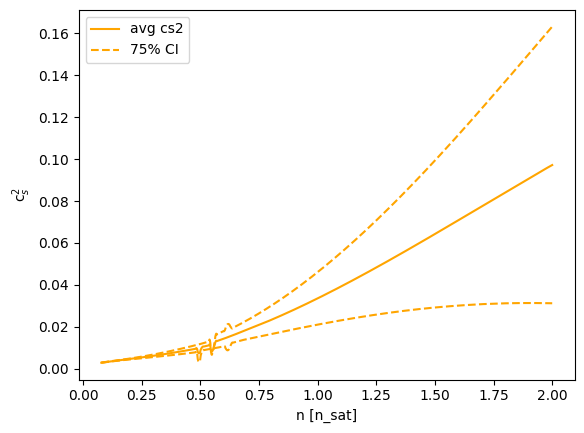

In [8]:
plt.plot(n_ceft, cs2_ceft_avg, color='orange', label='avg cs2')

plt.plot(n_ceft, cs2_ceft_avg+cs2_ceft_width/2, '--', color='orange', label='75% CI')
plt.plot(n_ceft, cs2_ceft_avg-cs2_ceft_width/2, '--', color='orange')


plt.ylabel(r'c$_s^2$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()



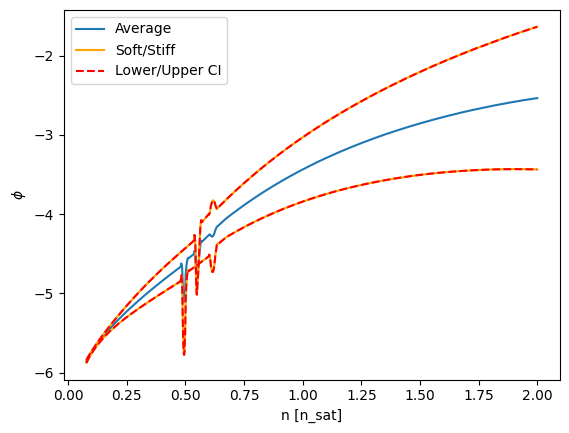

In [9]:
phi_ceft_lower = hel.get_phi(cs2_ceft_lower)
phi_ceft_upper = hel.get_phi(cs2_ceft_upper)
phi_ceft_width = phi_ceft_upper-phi_ceft_lower
phi_ceft_avg = (phi_ceft_upper+phi_ceft_lower)/2
phi_ceft_sigma = hel.CI_to_sigma(phi_ceft_width)

plt.plot(n_ceft, phi_ceft_avg, label='Average')
plt.plot(n_ceft, phi_ceft_lower, color='orange')
plt.plot(n_ceft, phi_ceft_upper, color='orange', label='Soft/Stiff')
plt.plot(n_ceft, phi_ceft_avg+phi_ceft_width/2, '--', color='red', label='Lower/Upper CI')
plt.plot(n_ceft, phi_ceft_avg-phi_ceft_width/2, '--', color='red')
plt.ylabel(r'$\phi$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()


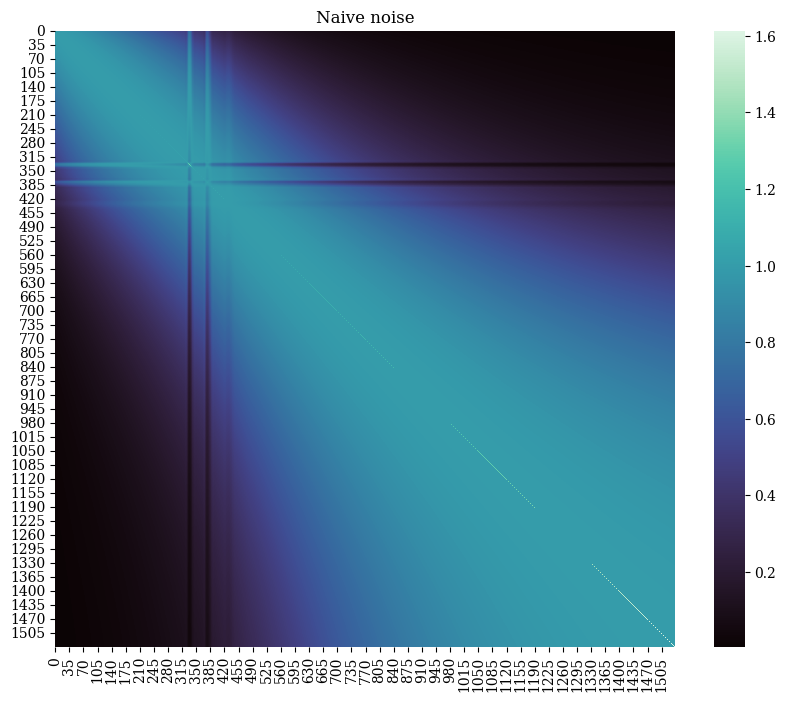

In [98]:
kern = db.Kernel('SE', sigma = 1, l = 1)
K11 = kern.compute(phi_ceft_avg)

noise_kern = K11 + np.diag(phi_ceft_sigma**2)
kern.visualise_kernel(noise_kern, 'Naive noise', annotation=False)


# GPR

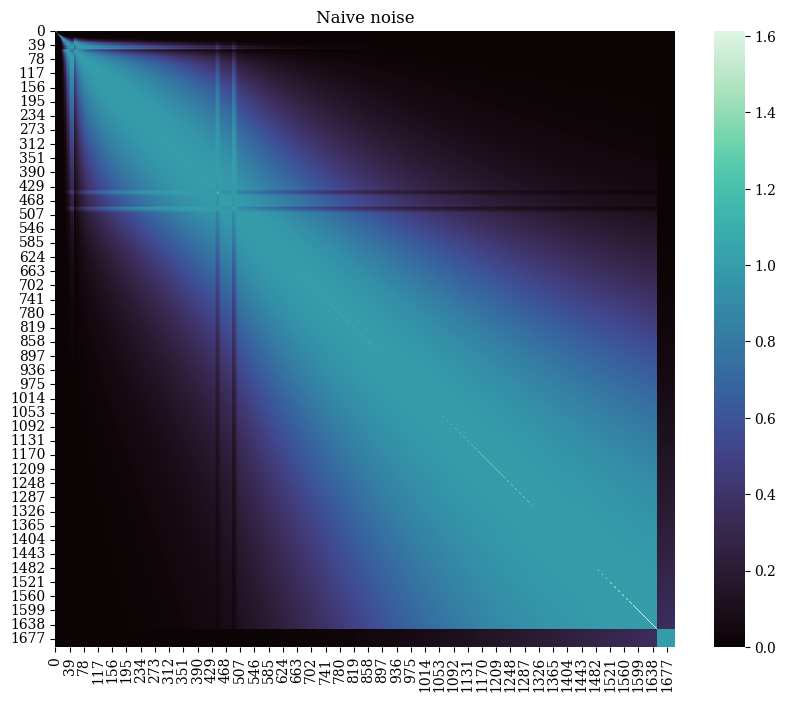

In [24]:
kern = db.Kernel('SE', sigma = 1, l = 1)
K11 = kern.compute(hel.get_phi(cs2_train))

noise_kern = K11 + np.diag(phi_sigma_train**2)
kern.visualise_kernel(noise_kern, 'Naive noise', annotation=False)


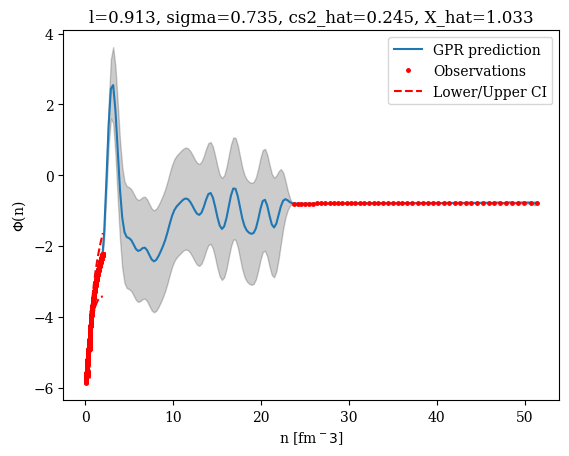

In [11]:
cs2_hat, nu_hat, l_hat, X_hat = hel.get_hype_samples()

kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)

n_pqcd, cs2_pqcd = hel.get_pqcd(X_hat, size=50)

x_train =  np.concatenate((n_ceft, n_pqcd))
cs2_train =  np.concatenate((cs2_ceft_avg, cs2_pqcd))

phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
phi_sigma_train = np.concatenate((phi_ceft_sigma, phi_pqcd_sigma))
phi_train = hel.get_phi(cs2_train)
train_noise = phi_sigma_train**2

x_test = np.linspace(n_ceft[0], n_pqcd[-1], 200) # number density, starting val is ending val of n crust


gp = db.GP(kernel, hel.get_phi(cs2_hat))
gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

phi_test, sig = gp.posterior()


plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.plot(x_train, phi_train, 'r.', markersize=5, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$\Phi$(n)')
plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}, X_hat={X_hat:.3f}")

plt.plot(n_ceft, phi_ceft_avg+phi_ceft_width/2, '--', color='red', label='Lower/Upper CI')
plt.plot(n_ceft, phi_ceft_avg-phi_ceft_width/2, '--', color='red')

plt.legend()
plt.show()



# eos uncertainties

$$c_s^2 = \frac{1}{e^{-\phi}+1}$$ 
$$\sigma_{c_s^2} = |\frac{\partial {c_s^2}}{\partial \phi}| \sigma_{\phi} = \frac{e^{-\phi}}{(e^{-\phi}+1)^2}| \sigma_{\phi}$$

In [12]:
eos = db.EosProperties(x_test, phi_test, epsi_0 = e_crust[-1], p_0 = p_crust[-1], mu_0=mu_ini)

In [13]:
eos_prop_results = eos.get_all()

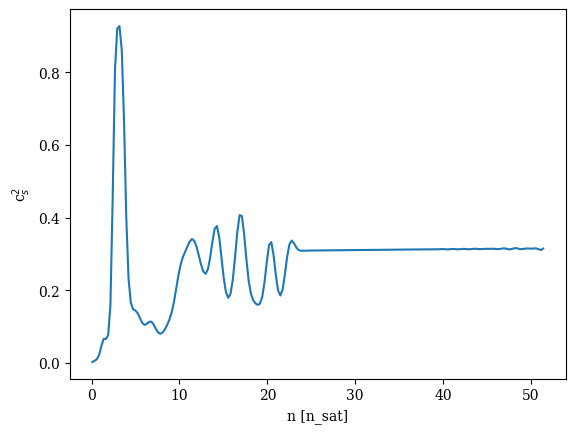

In [17]:
plt.plot(x_test, eos_prop_results['cs2'])
plt.xlabel('n [n_sat]')
plt.ylabel(r'c$_s^2$')
plt.show()

In [31]:
def cs2_uncertainty(phi, sig_phi):
    phi = phi.flatten()
    sig_cs2 = np.abs(np.exp(-phi)/((np.exp(-phi)+1)**2)) * sig_phi
    return sig_cs2

In [32]:
sig_cs2 = cs2_uncertainty(phi_test, sig)

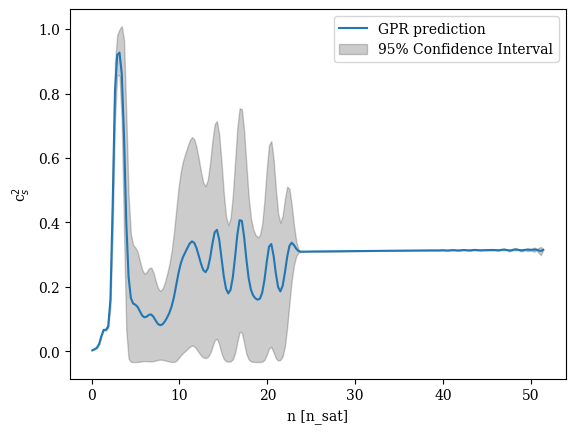

In [35]:
plt.plot(x_test, eos_prop_results['cs2'], label='GPR prediction')
plt.fill_between(x_test, eos_prop_results['cs2'] - 1.96 * sig_cs2, eos_prop_results['cs2'] + 1.96 * sig_cs2, alpha=0.2, color='k', label='95% Confidence Interval')
plt.xlabel('n [n_sat]')
plt.ylabel(r'c$_s^2$')
plt.legend()

plt.show()

In [37]:
def mu_uncertainty(sigma_cs2, n, n_init):
    sigma_integrand = sigma_cs2/n
    delta_n = np.diff(n, prepend=n_init)  # Increment in n

    sigma_integral_squared = np.cumsum((sigma_integrand * delta_n)**2)  # Variance propagation
    sigma_integral = np.sqrt(sigma_integral_squared)  # Standard deviation of the integral

    return sigma_integral


In [38]:
sigma_mu = mu_uncertainty(sig_cs2, x_test, n_ceft[-1])

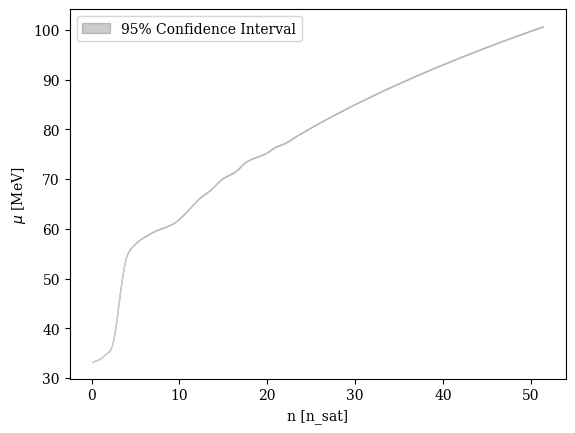

In [42]:
#plt.plot(x_test, eos_prop_results['mu'], label='GPR prediction')
plt.fill_between(x_test, eos_prop_results['mu'] - 1.96 * sigma_mu, eos_prop_results['mu'] + 1.96 * sigma_mu, alpha=0.2, color='k', label='95% Confidence Interval')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\mu$ [MeV]')
plt.legend()
plt.show()

In [ ]:
integrand = cs2 / n
sigma_integrand = sigma_cs2 / n

# Step 2: Perform cumulative integration for mu and propagate uncertainty
delta_n = np.diff(n, prepend=n[0])  # Increment in n
integral = np.cumsum(integrand * delta_n)  # Cumulative integral of integrand
sigma_integral_squared = np.cumsum((sigma_integrand * delta_n)**2)  # Variance propagation
sigma_integral = np.sqrt(sigma_integral_squared)  # Standard deviation of the integral

# Step 3: Compute mu and its uncertainty
mu = mu_0 + integral
sigma_mu = sigma_integral

# Output mu and its uncertainty
print("mu:", mu)
print("Uncertainty in mu:", sigma_mu)


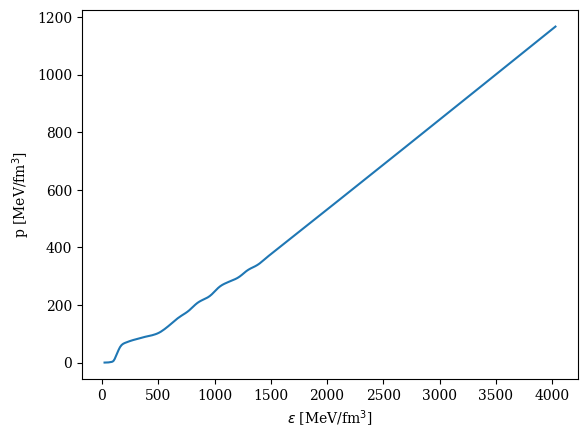

In [21]:
plt.plot(eos_prop_results["epsilon"], eos_prop_results["pressure2"])
plt.xlabel(r'$\epsilon$ [MeV/fm$^3$]')
plt.ylabel(r'p [MeV/fm$^3$]')
plt.show()    